In [11]:
from platform import python_version
import os
import time, datetime
import numpy as np
import pandas as pd

from tqdm import tqdm
from argparse import ArgumentParser
from collections import OrderedDict
import PIL
from PIL import Image, ImageOps
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2

import torch
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms
from torchvision.transforms import ToTensor
from torchvision.io import read_image
from pytorch_lightning.metrics.functional import accuracy

import pytorch_lightning as pl
import torchmetrics as tm

from openvino.inference_engine import IENetwork, IECore
print(python_version())

3.7.10


In [10]:
# DA IMPORTARE IN CASO DI DEBUGGING
#import pdb; pdb.set_trace() ################################ DEBUG #############################################
# COMANDO PER CREARE IL MODELLO IN IR:
#1 => lanciare "C:\Program Files (x86)\Intel\openvino_2021\bin\setupvars.bat"
#2 => python "C:/Program Files (x86)/Intel/openvino_2021/deployment_tools/model_optimizer/mo.py" --input_model SNDE_UNet_cpu_traced.onnx

## Settings

In [2]:
test_path        = '\\\\ha07\\DL\\Images\\snde_inner_segmentation\\test'
results_path     = '.\\results'
image_scaling    = 0.25 # Percentage of input image: 1 = 100% (image not rescaled), 0.25 = 25% (imaged rescaled as 25% of original dimensions)
print_all_images = False # True if printin all images during test
pred_threshold   = 0.2  # Threshold used to classify images

C:\Users\Alessandro.Bonvini\Anaconda3\envs\PyTorchOpenVino20214Py37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Define test dataset

In [59]:
def preprocess(img, flip=''):
    '''
    Perform image preprocessing
    '''
    # Perform image resizing
    img = cv2.resize(img, (384, 256), interpolation=cv2.INTER_NEAREST)
    
    # Define common transforms
    transforms_list = [transforms.ToTensor(), transforms.CenterCrop((256, 256))]
    
    # Add data augmentation: horizontal or vertical flip, ...
    if flip == 'h':
        transforms_list.append(transforms.RandomHorizontalFlip(p=1))
    elif flip == 'v':
        transforms_list.append(transforms.RandomVerticalFlip(p=1))

    # Apply transforms
    tfms = transforms.Compose(transforms_list)
    img_t = torch.stack([tfms(img)]).float()
        
    # Normalize image
    if img_t.max() > 1:
        img_t = img_t / 255.
        
    return img_t.squeeze(dim=0)

def preprocess_test(img, conv_type=torch.uint8, normalize=True):
    '''
    Perform image preprocessing
    '''
    # Perform image resizing
    img_t = torch.Tensor(img).to(conv_type).permute(2, 0, 1)
    
    # If normalize
    if normalize and img_t.max() > 1:
        img_t = img_t / 255
    
    return img_t.squeeze(dim=0)

class ImageTestDataset(Dataset):
    def __init__(self, img_dir, annotations_file, scale=1):
        
        self.img_dir = img_dir
        self.annotations_file = annotations_file
        self.scale = scale
        self.img_labels = pd.read_csv(annotations_file, header=None)

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, i):
        # Free cache if gpus
        if gpus > 0:  
            torch.cuda.empty_cache()
        
        # Get image and label
        label = self.img_labels.iloc[i, 1]
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[i, 0])
        
        # Open and preprocess image
        img = ImageOps.grayscale(Image.open(img_path))
        img = preprocess(img, self.scale)

        return img, label

In [9]:
# Loading test data
test_dataset = ImageTestDataset(test_path, test_path + "\\annotations.txt", image_scaling)

## Define Open Vino Inference Engine

In [5]:
class OVNetwork:
    
    def __init__(self, device="GPU"):
        self.model_name = None
        self.ie_core = IECore()
        self.ie_net = None
        self.exec_net = None
        self.in_layer = None
        self.out_layer = None
        self.device_name = device
    
    def load_model(self, model_name):
        '''
        Import the IR model into IR
        '''
        # Save model name
        self.model_name = model_name
        
        # Load model (xml) and weights (bin) to IENetwork
        self.ie_net = self.ie_core.read_network(model=model_name+".xml", weights=model_name+".bin")

        # Check if the network has some unsupported layer
        supp_layers = self.ie_core.query_network(network=self.ie_net, device_name=self.device_name)
        
        #unsupp_layers = [l for l in self.ie_net.layers.keys() if l not in supp_layers]
        #if len(unsupp_layers) > 0:
        #    print ("ERROR: found unsupported layers:")
        #    print (unsupp_layers)
        #    return

        # Load network in IE and get the executable network
        self.exec_net = self.ie_core.load_network(self.ie_net, self.device_name)

        # Get also input and output layers for requests
        self.in_layer = next(iter(self.exec_net.inputs))
        self.out_layer = next(iter(self.exec_net.outputs))

        print ("Network successfully loaded in IE.")

        return
    
    def get_result(self):
        '''
        Get result of last request
        '''
        return self.exec_net.requests[0].outputs[self.out_layer]
    
    def sync_request(self, image):
        '''
        Perform syncronous request to IE executable network
        '''
        self.exec_net.infer({self.in_layer: image})
        return self.get_result()
    
    def async_request(self, image, req_id=0):
        '''
        Perform asyncronous request to IE executable network
        '''
        return self.exec_net.start_async(request_id=req_id, inputs={self.in_layer: image})
    
    def check_status(self, req_id=0):
        '''
        Check the status of the inference request
        '''
        return self.exec_net.requests[req_id].wait(-1)

## Test open vino newtork

In [6]:
# Load the model to IE
ov_net = OVNetwork("GPU")
ov_net.load_model("ONNX_models\\SNDE_BrainUNet_cpu_traced")

Network successfully loaded in IE.


C:\Users\Alessandro.Bonvini\Anaconda3\envs\PyTorchOpenVino20214Py37\lib\site-packages\ipykernel_launcher.py:35: DeprecationWarning: 'inputs' property of ExecutableNetwork class is deprecated. To access DataPtrs user need to use 'input_data' property of InputInfoCPtr objects which can be accessed by 'input_info' property.


#### Test using one image

In [60]:
img = cv2.imread(f'{test_path}\\sBAD (46).png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = preprocess(img, image_scaling).unsqueeze(dim=0)
start = time.time()
# Compute open vino output
out_mask = ov_net.sync_request(img)
print(f"Time: {(time.time() - start):.3f} seconds")  
out_mask

Time: 0.072 seconds


C:\Users\Alessandro.Bonvini\Anaconda3\envs\PyTorchOpenVino20214Py37\lib\site-packages\ipykernel_launcher.py:46: DeprecationWarning: 'outputs' property of InferRequest is deprecated. Please instead use 'output_blobs' property.


array([[[[1.9720301e-05, 2.4243252e-05, 1.8626328e-05, ...,
          1.7223309e-05, 1.5174129e-05, 1.7505565e-05],
         [1.9989091e-05, 2.2934026e-05, 3.7868085e-05, ...,
          1.3336536e-05, 1.3645966e-05, 1.7026388e-05],
         [2.0578316e-05, 3.9295039e-05, 7.4551965e-05, ...,
          2.2929889e-05, 1.7080838e-05, 1.7072354e-05],
         ...,
         [1.1351976e-05, 1.1467771e-05, 1.6771122e-05, ...,
          3.1971293e-05, 2.1132748e-05, 1.7560407e-05],
         [1.2148999e-05, 1.5963757e-05, 1.5740850e-05, ...,
          3.7685615e-05, 3.0344747e-05, 2.4684670e-05],
         [1.4177742e-05, 1.3670204e-05, 1.8127505e-05, ...,
          2.1466720e-05, 1.9313762e-05, 1.7208335e-05]]]], dtype=float32)

In [31]:
# Conver open vino output to torch tensor
out_mask = torch.Tensor(out_mask)
out_mask = out_mask.detach().squeeze() 

Score: 1.0


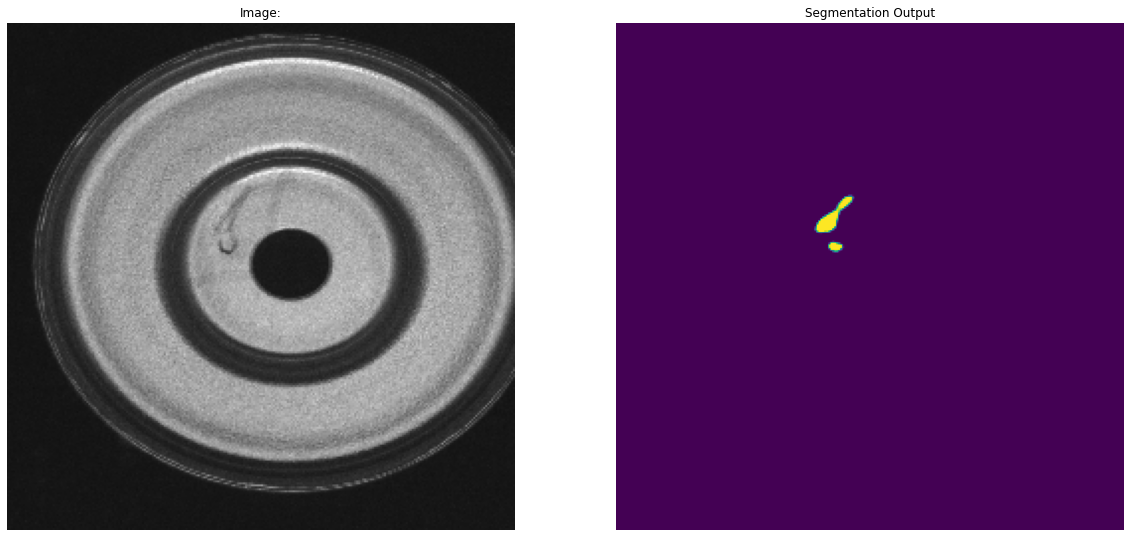

In [48]:
print(f'Score: {out_mask.max()}')
plt.figure(figsize=(20,60));
plt.subplot(121);
plt.imshow(img.cpu().squeeze().permute(1, 2, 0));
plt.title('Image:')
plt.axis('off');
plt.subplot(122);
#plt.imshow(out > 0.455);
plt.imshow(out_mask.cpu());
plt.title('Segmentation Output')
plt.axis('off');

#### Debug C++

In [77]:
img_int = cv2.imread(f'D:\\Temp\\DEBUG\\test.png')
img_int = cv2.cvtColor(img_int, cv2.COLOR_BGR2RGB)
img_int = preprocess_test(img_int).unsqueeze(dim=0)
print(img_int.size())
print(img.type())

torch.Size([1, 3, 256, 256])
torch.FloatTensor


In [78]:
start = time.time()
# Compute open vino output
out_mask_int = ov_net.sync_request(img_int)
print(f"Time: {(time.time() - start):.3f} seconds")  
out_mask_int

Time: 0.094 seconds


C:\Users\Alessandro.Bonvini\Anaconda3\envs\PyTorchOpenVino20214Py37\lib\site-packages\ipykernel_launcher.py:46: DeprecationWarning: 'outputs' property of InferRequest is deprecated. Please instead use 'output_blobs' property.


array([[[[1.9720301e-05, 2.4243252e-05, 1.8626328e-05, ...,
          1.7223309e-05, 1.5174129e-05, 1.7505565e-05],
         [1.9989091e-05, 2.2934026e-05, 3.7868085e-05, ...,
          1.3336536e-05, 1.3645966e-05, 1.7026388e-05],
         [2.0578316e-05, 3.9295039e-05, 7.4551965e-05, ...,
          2.2929889e-05, 1.7080838e-05, 1.7072354e-05],
         ...,
         [1.1351976e-05, 1.1467771e-05, 1.6771122e-05, ...,
          3.1971293e-05, 2.1132748e-05, 1.7560407e-05],
         [1.2148999e-05, 1.5963757e-05, 1.5740850e-05, ...,
          3.7685615e-05, 3.0344747e-05, 2.4684670e-05],
         [1.4177742e-05, 1.3670204e-05, 1.8127505e-05, ...,
          2.1466720e-05, 1.9313762e-05, 1.7208335e-05]]]], dtype=float32)

In [79]:
# Conver open vino output to torch tensor
out_mask_int = torch.Tensor(out_mask_int)
out_mask_int = out_mask_int.detach().squeeze() 

Score: 1.0


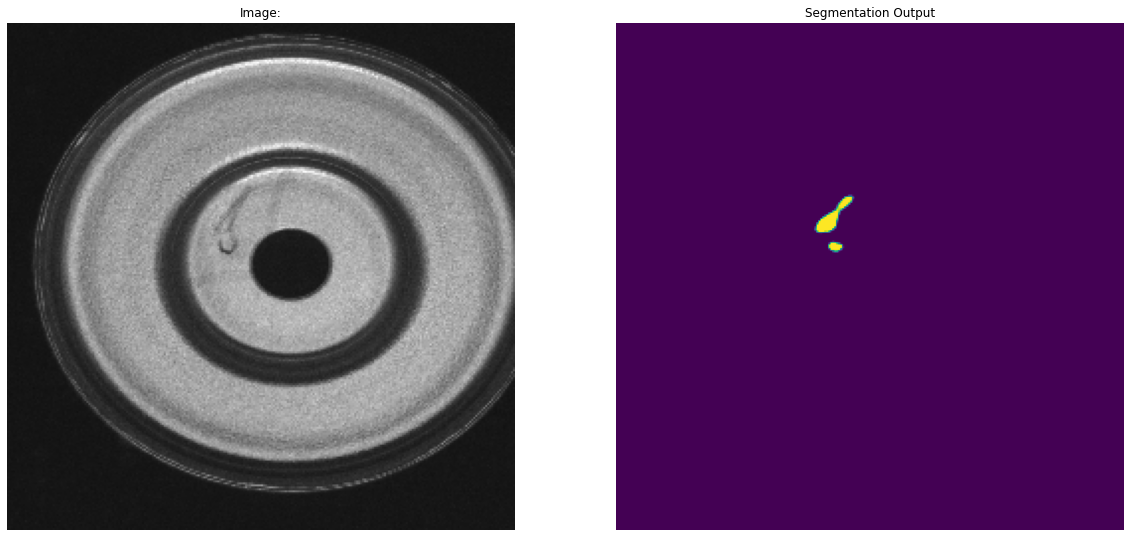

In [80]:
print(f'Score: {out_mask_int.max()}')
plt.figure(figsize=(20,60));
plt.subplot(121);
plt.imshow(img_int.cpu().squeeze().permute(1, 2, 0));
plt.title('Image:')
plt.axis('off');
plt.subplot(122);
#plt.imshow(out > 0.455);
plt.imshow(out_mask_int.cpu());
plt.title('Segmentation Output')
plt.axis('off');

#### Test sync request

In [15]:
test_loader = DataLoader(test_dataset, batch_size=1)

# Compute average prediction time and save results
ts_tot = list()
y_test = list()
y_hats_test = list()
accs = list()
scores_f = ['Image_label; Score\n']
scores = []
i = 1

if print_all_images:
    fig, axs = plt.subplots(test_loader.__len__(), 2, figsize=(17, 400))

for batch in test_loader:
    x, y = batch
    if gpus > 0:
        x = x.cuda()
    # Log start time
    ts_start = time.time()
    # Compute output mask from input image using syncronous requests
    out_mask = ov_net.sync_request(x)
    out_mask = torch.Tensor(out_mask)
    out_mask = model.activ_fn_out(out_mask)
    # Log end time
    ts_end = time.time()
    # Compute prediction from output mask = returns 1 if there is at least one defect, otherwise 0
    y_hat = torch.count_nonzero(out_mask > self.pred_threshold) > 0
    # Compute total time in ms
    ts_tot.append((ts_end - ts_start) * 1000)
    # Update accuracy and score
    y_hat = y_hat.cpu()
    accs.append(accuracy(y_hat.unsqueeze(dim=0), y))
    score = out_mask.max().item()
    scores_f.append(f'{y.item()}; {score}\n')
    scores.append([y.item(), score])
    # Append results
    y_hats_test.append(y_hat.item())
    y_test.append(y)
    # Save computed mask
    save_image((out_mask > model.pred_threshold).double(), f'{results_path}\\mask_{i}.png')
    # Update progress bar
    clear_output(wait=True)
    print(f'Test progress: {i}/{pretos_dm.test_data.__len__()}')
    
    if print_all_images:
        # Print images
        axs[i-1, 0].imshow(x.cpu().squeeze(), cmap="gray", aspect='auto');
        axs[i-1, 0].set_title(f'Image - Class: {y.item()}')
        axs[i-1, 0].axis('off');
        axs[i-1, 1].imshow(out_mask.detach().squeeze().cpu(), aspect='auto');
        axs[i-1, 1].set_title(f'Segm Output - Class: {y_hat.item()}; Score: {score}')
        axs[i-1, 1].axis('off');
    
    i = i + 1
    
# Save scores file
scores_file = open(f'{results_path}\\scores.csv', 'w')
scores_file.writelines(scores_f)
scores_file.close()

# Print results
print("Mean test accuracy: ", torch.tensor(accs).mean().item())
print("Mean test prediction time [ms]: ", torch.tensor(ts_tot).mean().item())
print("Predictions:")
print(torch.tensor(y_hats_test))
print("Target:")
print(torch.tensor(y_test))


C:\Users\Alessandro.Bonvini\Anaconda3\envs\PyTorchOpenVinoPy37\lib\site-packages\ipykernel_launcher.py:46: DeprecationWarning: 'outputs' property of InferRequest is deprecated. Please instead use 'output_blobs' property.


Execute on device:  GPU
Mean test accuracy:  1.0
Mean test prediction time [ms]:  4.690614700317383
Predictions:
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1])


In [16]:
test_loader = DataLoader(test_dataset, batch_size=test_dataset.__len__())
_, y_test = next(iter(test_loader))
print('Targets:')
print(y_test)

Targets:
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1])


In [ ]:
# Print scores histogram
scores_df = pd.DataFrame(scores, columns=['label', 'score'])
scores_df.sort_values(by=['score'])
fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(111)
scores_df[scores_df['label'] == 0].hist(column = 'score', color = 'green', alpha = 0.5, ax=ax1)
scores_df[scores_df['label'] == 1].hist(column = 'score', color = 'red', alpha = 0.5, ax=ax1)